# Train, evaluate, and test


## Lab setup

### Install Custom Vision Service SDK

In [ ]:
# Install Custom Vision Service SDK  in the current Jupyter kernel
import sys
!{sys.executable} -m pip install azure-cognitiveservices-vision-customvision

### Get example images


In [15]:
%%sh
wget -nv https://azureailabs.blob.core.windows.net/aerialsamples/aerial.zip
unzip aerial.zip

Archive:  aerial.zip
   creating: aerial/test/
  inflating: aerial/test/.DS_Store   
   creating: aerial/test/Barren/
  inflating: aerial/test/Barren/.DS_Store  
  inflating: aerial/test/Barren/barren-1.png  
  inflating: aerial/test/Barren/barren-10.png  
  inflating: aerial/test/Barren/barren-2.png  
  inflating: aerial/test/Barren/barren-3.png  
  inflating: aerial/test/Barren/barren-4.png  
  inflating: aerial/test/Barren/barren-5.png  
  inflating: aerial/test/Barren/barren-6.png  
  inflating: aerial/test/Barren/barren-7.png  
  inflating: aerial/test/Barren/barren-8.png  
  inflating: aerial/test/Barren/barren-9.png  
   creating: aerial/test/Cultivated/
  inflating: aerial/test/Cultivated/.DS_Store  
  inflating: aerial/test/Cultivated/cultivated-1.png  
  inflating: aerial/test/Cultivated/cultivated-10.png  
  inflating: aerial/test/Cultivated/cultivated-2.png  
  inflating: aerial/test/Cultivated/cultivated-3.png  
  inflating: aerial/test/Cultivated/cultivated-4.png  
  infl

2018-10-13 08:18:57 URL:https://azureailabs.blob.core.windows.net/aerialsamples/aerial.zip [37416592/37416592] -> "aerial.zip" [1]


### Get the training and prediction keys
To get the keys used in this example, navigate to Custom Vision Training blade in Azure Portal and retrieve the training key from the **Keys** page under **Resource Management** section. Repeat for Custom Vision Prediction service.

In [ ]:
training_key = '<your training key>'
prediction_key = '<your prediction key>'

In [18]:
training_key = 'b1cbbf0f9a054ef481113c9efec1fe4d'
prediction_key = 'b01851d0bbe24e9ba3c542ce84306787'

trainer = training_api.TrainingApi(training_key)

### Create a Custom Vision Service project

In [24]:
from azure.cognitiveservices.vision.customvision.training import training_api
from azure.cognitiveservices.vision.customvision.training.models import ImageUrlCreateEntry

project_name = 'AerialClassifier'

# Check if the project with that name exists
project_id = None
for project in trainer.get_projects():
    if project.name == project_name:
        project_id = project.id
        print("Found existing project: {0}".format(project_id))
        break
# Create a new project        
if project_id == None:
    print("Creating a new project")
    project = trainer.create_project(project_name)
    project_id = project.id


Creating a new project


## Train

### Upload and tag images 
The API used to upload images `create_images_from_files` uploads a batch of images at a time. The maximum supported batch size is 64. 

In [25]:
import os
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region

# Define a utility function to upload a list of images
def upload_images(training_key, project_id, image_list, batch_size=64):
    trainer = training_api.TrainingApi(training_key)
    print("Starting upload ...")
    image_batches = [image_list[start: start+batch_size] for start in range(0, len(image_list), batch_size)]
    for batch in image_batches:
        image_entry_batch = []
        for tag, pathname, file_name in batch:
            with open(pathname, mode='rb') as image_contents:
                image_entry_batch.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), tag_ids=[tag]))
        summary = trainer.create_images_from_files(project_id, images=image_entry_batch)
    print("Done.")


In [26]:
# Create tags. Check for existing tags before creating new ones
tags = trainer.get_tags(project_id)
if len(tags) == 0:
    tags = {tag: trainer.create_tag(project_id, tag).id for tag in ['Barren', 'Developed', 'Cultivated']}

# Upload images
base_folder = 'aerial/train'
image_list = [(tags[folder], os.path.join(base_folder, folder, filename), filename)  for folder in ['Barren','Cultivated', 'Developed'] for filename in os.listdir(os.path.join(base_folder, folder))]
upload_images(training_key, project_id, image_list, batch_size = 64)

Starting upload ...
Done.


### Train the first iteration of the project


In [27]:
import time

def train(training_key, project_id):
    trainer = training_api.TrainingApi(training_key)
    print("Starting training...")
    try:
        iteration = trainer.train_project(project.id)
    except:
        print("No need to retrain")
        return
    
    while (iteration.status != "Completed"):
        iteration = trainer.get_iteration(project.id, iteration.id)
        print ("Training status: " + iteration.status)
        time.sleep(2)

    # The iteration is now trained. Make it the default project endpoint
    trainer.update_iteration(project_id, iteration.id, is_default=True)
    print("Done")
    return iteration.id

In [28]:
# Start training
iteration_id = train(training_key, project_id)

Starting training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Done


### Get iteration performance measures

In [29]:
def display_iteration_performance(training_key, project_id, iteration_id):
    trainer = training_api.TrainingApi(training_key)
    performance = trainer.get_iteration_performance(project_id, iteration_id)
    print("Precision: {0}".format(performance.precision))
    print("Recall: {0}".format(performance.recall))
    for tag_perf in performance.per_tag_performance:
        print("Tag:\t{0}    \tPrecision:\t{1}\t    Recall:\t{2}".format(tag_perf.name, tag_perf.precision, tag_perf.recall))

In [30]:
display_iteration_performance(training_key, project_id, iteration_id)

Precision: 0.9902977
Recall: 0.913333356
Tag:	Barren    	Precision:	1.0	    Recall:	0.933333337
Tag:	Cultivated    	Precision:	0.978198946	    Recall:	0.9
Tag:	Developed    	Precision:	0.9929078	    Recall:	0.9066667


### Upload additional images

In [31]:
# Upload images
base_folder = 'aerial/train'
folder = 'Developed-SecondBatch'
image_list = [(tags['Developed'], os.path.join(base_folder, folder, filename), filename)  for filename in os.listdir(os.path.join(base_folder, folder))]

upload_images(training_key, project_id, image_list, batch_size = 64)

Starting upload ...
Done.


### Re-train the project


In [32]:
# Start training
iteration_id = train(training_key, project_id)

Starting training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Done


In [33]:
display_iteration_performance(training_key, project_id, iteration_id)

Precision: 0.9896605
Recall: 0.9519996
Tag:	Barren    	Precision:	1.0	    Recall:	0.98
Tag:	Cultivated    	Precision:	0.9791667	    Recall:	0.92
Tag:	Developed    	Precision:	0.9896635	    Recall:	0.9550731


## Test

### Download test images

In [34]:
%%sh
mkdir test_images
cd test_images
wget https://github.com/jakazmie/AIDays/raw/master/DeveloperTrack/01-CustomVisionService/samples/barren-1.png
wget https://github.com/jakazmie/AIDays/raw/master/DeveloperTrack/01-CustomVisionService/samples/cultivated-1.png
wget  https://github.com/jakazmie/AIDays/raw/master/DeveloperTrack/01-CustomVisionService/samples/developed-1.png

--2018-10-13 08:25:29--  https://github.com/jakazmie/AIDays/raw/master/DeveloperTrack/01-CustomVisionService/samples/barren-1.png
Resolving github.com (github.com)... 192.30.255.112, 192.30.255.113
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jakazmie/AIDays/master/DeveloperTrack/01-CustomVisionService/samples/barren-1.png [following]
--2018-10-13 08:25:29--  https://raw.githubusercontent.com/jakazmie/AIDays/master/DeveloperTrack/01-CustomVisionService/samples/barren-1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.48.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.48.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91989 (90K) [image/png]
Saving to: ‘barren-1.png’

     0K .......... .......... .......... .......... .......... 55%  422K 0s
    50K .......... .......... .....

### Display test images

The images we will use for testing are located in the `samples` folder.

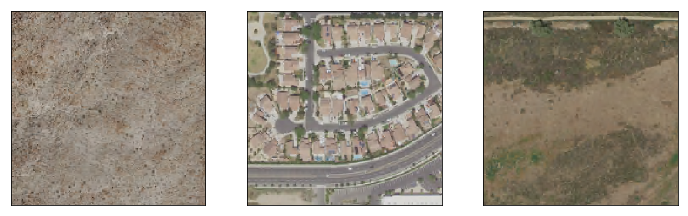

In [37]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

images_dir = 'test_images'
images = [os.path.join(images_dir, file) for file in os.listdir(images_dir)]

figsize=(10, 8)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
for ax, image_path in zip(axis.flat[0:], images):
    image = Image.open(image_path)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

 ### Test with `curl`
 

In [38]:
%env PROJECT_ID=$project_id
%env PREDICTION_KEY=$prediction_key

env: PROJECT_ID=b167c9e0-a0ec-4f15-85ac-5e88af787308
env: PREDICTION_KEY=b01851d0bbe24e9ba3c542ce84306787


In [39]:
%%sh

curl -X POST https://southcentralus.api.cognitive.microsoft.com/customvision/v2.0/Prediction/$PROJECT_ID/image -H "Prediction-Key: $PREDICTION_KEY"  -H "Content-Type: application/octet-stream" --data-binary @test_images/developed-1.png

{"id":"a25a7389-d54e-413d-b817-d822164c4ef1","project":"b167c9e0-a0ec-4f15-85ac-5e88af787308","iteration":"022feb92-043d-4ceb-9943-57ecf2999231","created":"2018-10-13T15:31:16.8435073Z","predictions":[{"probability":0.9995019,"tagId":"58840f7b-535c-4827-8c20-760fa4291b0b","tagName":"Developed"},{"probability":0.00755663263,"tagId":"f0b49771-dbd5-4a47-b582-fc4c30da8a0d","tagName":"Cultivated"},{"probability":9.00798E-06,"tagId":"6f8f7222-c109-4095-b41c-e5ca06636ffa","tagName":"Barren"}]}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92587  100   491  100 92096    491  92096  0:00:01  0:00:01 --:--:-- 92587


### Call the prediction endpoint using Python SDK

Python SDK wraps the prediction endpoint in the `prediction_endpoint` class. The class exposes the `predict_image` method that takes a Python File Object as parameter. The following code snippet defines a utility function `classify_image` that invokes the prediction endpoint and parses the results returned from the service.

In [47]:
from azure.cognitiveservices.vision.customvision.prediction import prediction_endpoint
from azure.cognitiveservices.vision.customvision.prediction.prediction_endpoint import models

def classify_image(project_id, prediction_key, image_path):
    predictor = prediction_endpoint.PredictionEndpoint(prediction_key)
    with open(image_path, mode='rb') as image:
      result = predictor.predict_image(project_id, image)
    
    print(result)
    probs = [prediction.probability for prediction in result.predictions]
    print(probs)
    max_prob = max(probs)
    max_index = probs.index(max_prob)
    tag = result.predictions[max_index].tag_name

    return tag, max_prob

We will now invoke the prediction endpoint and display the results returned by the service.

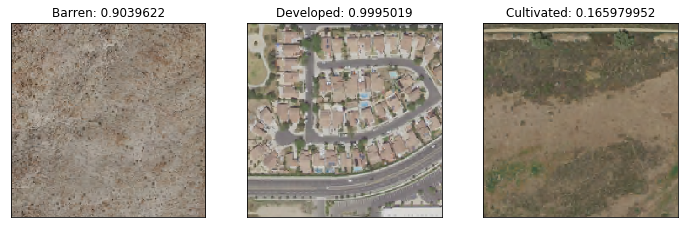

In [42]:
figsize=(10, 8)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
for ax, image_path in zip(axis.flat[0:], images):
    tag, prob = classify_image(project_id, prediction_key, image_path)
    ax.set_title(tag + ': ' + str(prob))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    image = Image.open(image_path)
    ax.imshow(image)

In [48]:
image_path = 'test_images/cultivated-1.png'
result = classify_image(project_id, prediction_key, image_path )
print(result)

{'additional_properties': {}, 'id': 'b2415415-3122-4f99-892d-9ef95f75a70c', 'project': 'b167c9e0-a0ec-4f15-85ac-5e88af787308', 'iteration': '022feb92-043d-4ceb-9943-57ecf2999231', 'created': datetime.datetime(2018, 10, 13, 15, 36, 4, 189553, tzinfo=<isodate.tzinfo.Utc object at 0x104babe80>), 'predictions': [<azure.cognitiveservices.vision.customvision.prediction.models.prediction_py3.Prediction object at 0x114904278>, <azure.cognitiveservices.vision.customvision.prediction.models.prediction_py3.Prediction object at 0x114904e48>, <azure.cognitiveservices.vision.customvision.prediction.models.prediction_py3.Prediction object at 0x114904518>]}
[0.165979952, 0.08627949, 0.000913788332]
('Cultivated', 0.165979952)
